In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
from module import Model_Training
import warnings
warnings.filterwarnings('ignore')

2023-02-18 12:27:40.883112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 12:27:42.103123: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-02-18 12:27:42.103231: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LI

In [2]:
# full_img_path = '/mnt/d/Datasets/INbreast/full/'
roi_img_path = '/mnt/d/Datasets/INbreast/ROI/CLAHE/'
img_height = 300
img_width = 300
batch_size = 16
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 320 files belonging to 2 classes.
Found 80 files belonging to 2 classes.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train = train_ds.prefetch(AUTOTUNE)
val = val_ds.prefetch(AUTOTUNE)

In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)
test = test_ds.prefetch(AUTOTUNE)

Found 72 files belonging to 2 classes.


In [6]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            f' Epoch {epoch}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')

# Inception V3

In [39]:
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log='/home/jj/FYP/log/InceptionV3_INbreast_CLAHE/InceptionV3_INbreast_CLAHE_dense.csv',
    load_weights = False,
    save_weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_CLAHE/Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0     

## Fine Tune

In [41]:
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.L2(l2=0.1),
    train_log='/home/jj/FYP/log/InceptionV3_INbreast_CLAHE/InceptionV3_INbreast_CLAHE_Fine_Tune.csv',
    load_weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_CLAHE/Dense/best_model',
    save_weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_CLAHE/Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0   

## Figures

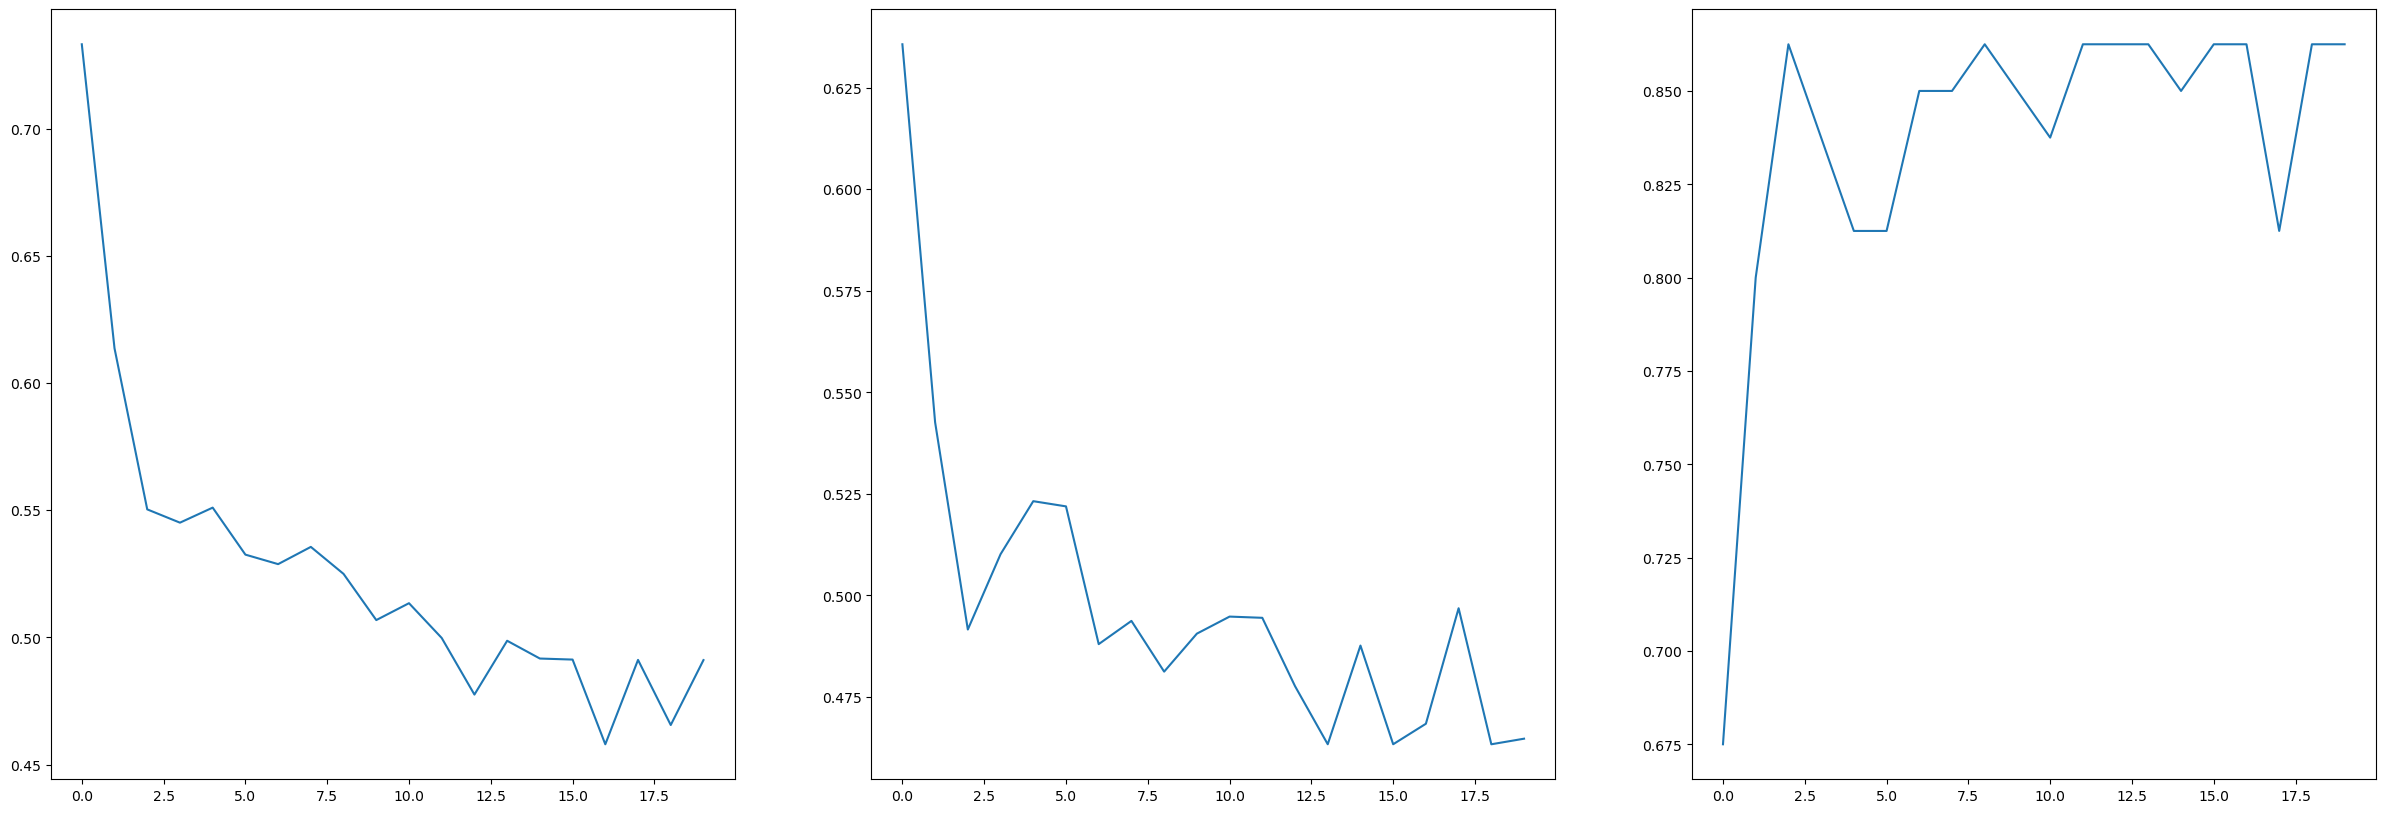

In [42]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(inception_dense_history['train_loss'])
plt.subplot(132)
plt.plot(inception_dense_history['val_loss'])
plt.subplot(133)
plt.plot(inception_dense_history['val_acc'])

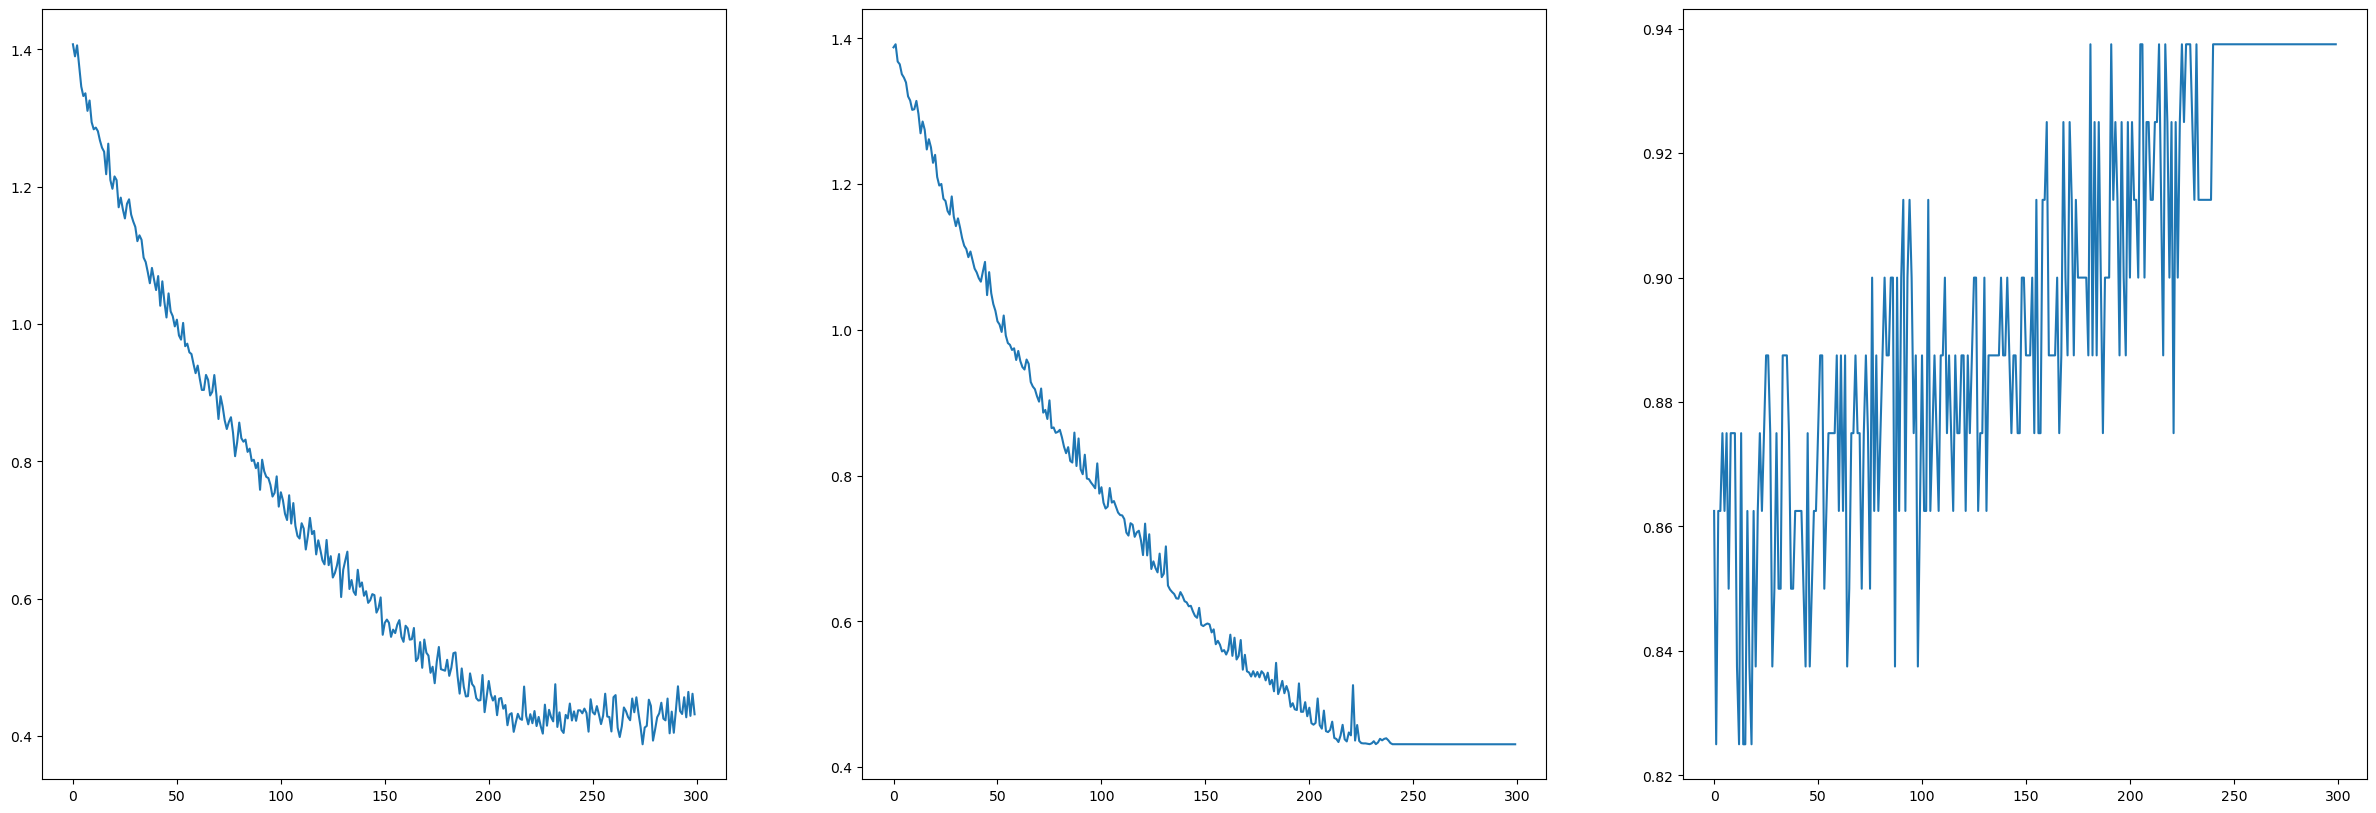

In [43]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(inception_fine_tune_history['train_loss'])
plt.subplot(132)
plt.plot(inception_fine_tune_history['val_loss'])
plt.subplot(133)
plt.plot(inception_fine_tune_history['val_acc'])


## Test

In [44]:
model.load_weights('/home/jj/FYP/Checkpoint/InceptionV3_INbreast_CLAHE/Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 0s 39ms/step - loss: 0.4202 - categorical_accuracy: 0.9306 - precision_4: 0.9592 - precision_5: 0.8696


# EfficientNet V2M

## Initialising

In [7]:
weights = '/home/jj/FYP/Checkpoint/Efficientnetv2m_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/Efficientnetv2m_INbreast_CLAHE/'
model, effnetv2m_dense_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 8)                 1024008   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                             

2023-02-18 12:28:18.575506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-18 12:28:21.336309: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-02-18 12:28:21.621556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-18 12:28:21.640299: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1c8cb820 initialized for platform CUDA (this does not guarantee tha

20/20 [==============================] - 23s 388ms/step - loss: 0.6504 - categorical_accuracy: 0.5875 - precision_2: 0.5447 - precision_3: 0.7260 - val_loss: 0.5499 - val_categorical_accuracy: 0.7875 - val_precision_2: 0.7556 - val_precision_3: 0.8286
Epoch 2/2
20/20 [==============================] - 5s 260ms/step - loss: 0.5537 - categorical_accuracy: 0.7844 - precision_2: 0.8071 - precision_3: 0.7667 - val_loss: 0.5047 - val_categorical_accuracy: 0.8125 - val_precision_2: 0.7778 - val_precision_3: 0.8571
Epoch 3/3
20/20 [==============================] - 5s 262ms/step - loss: 0.5158 - categorical_accuracy: 0.8281 - precision_2: 0.8333 - precision_3: 0.8235 - val_loss: 0.4632 - val_categorical_accuracy: 0.8125 - val_precision_2: 0.7660 - val_precision_3: 0.8788
Epoch 4/4
20/20 [==============================] - 6s 266ms/step - loss: 0.4990 - categorical_accuracy: 0.8500 - precision_2: 0.8794 - precision_3: 0.8268 - val_loss: 0.4682 - val_categorical_accuracy: 0.8500 - val_precision_2

## Fine Tuning

In [8]:
model, effnetv2m_fine_tune_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1024008   
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                           

2023-02-18 12:30:42.606535: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-18 12:30:42.606599: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-18 12:30:42.618250: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-18 12:30:42.618283: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

20/20 [==============================] - 20s 422ms/step - loss: 1.1725 - categorical_accuracy: 0.8281 - precision_4: 0.8571 - precision_5: 0.8056 - val_loss: 1.1017 - val_categorical_accuracy: 0.8625 - val_precision_4: 0.8372 - val_precision_5: 0.8919
Epoch 2/2
20/20 [==============================] - 6s 292ms/step - loss: 1.1638 - categorical_accuracy: 0.8375 - precision_4: 0.8759 - precision_5: 0.8087 - val_loss: 1.0987 - val_categorical_accuracy: 0.8625 - val_precision_4: 0.8372 - val_precision_5: 0.8919
Epoch 3/3
20/20 [==============================] - 6s 291ms/step - loss: 1.1486 - categorical_accuracy: 0.8375 - precision_4: 0.8705 - precision_5: 0.8122 - val_loss: 1.0904 - val_categorical_accuracy: 0.8625 - val_precision_4: 0.8372 - val_precision_5: 0.8919
Epoch 4/4
20/20 [==============================] - 6s 292ms/step - loss: 1.1521 - categorical_accuracy: 0.8281 - precision_4: 0.8676 - precision_5: 0.7989 - val_loss: 1.1003 - val_categorical_accuracy: 0.8625 - val_precision_4

## Figures

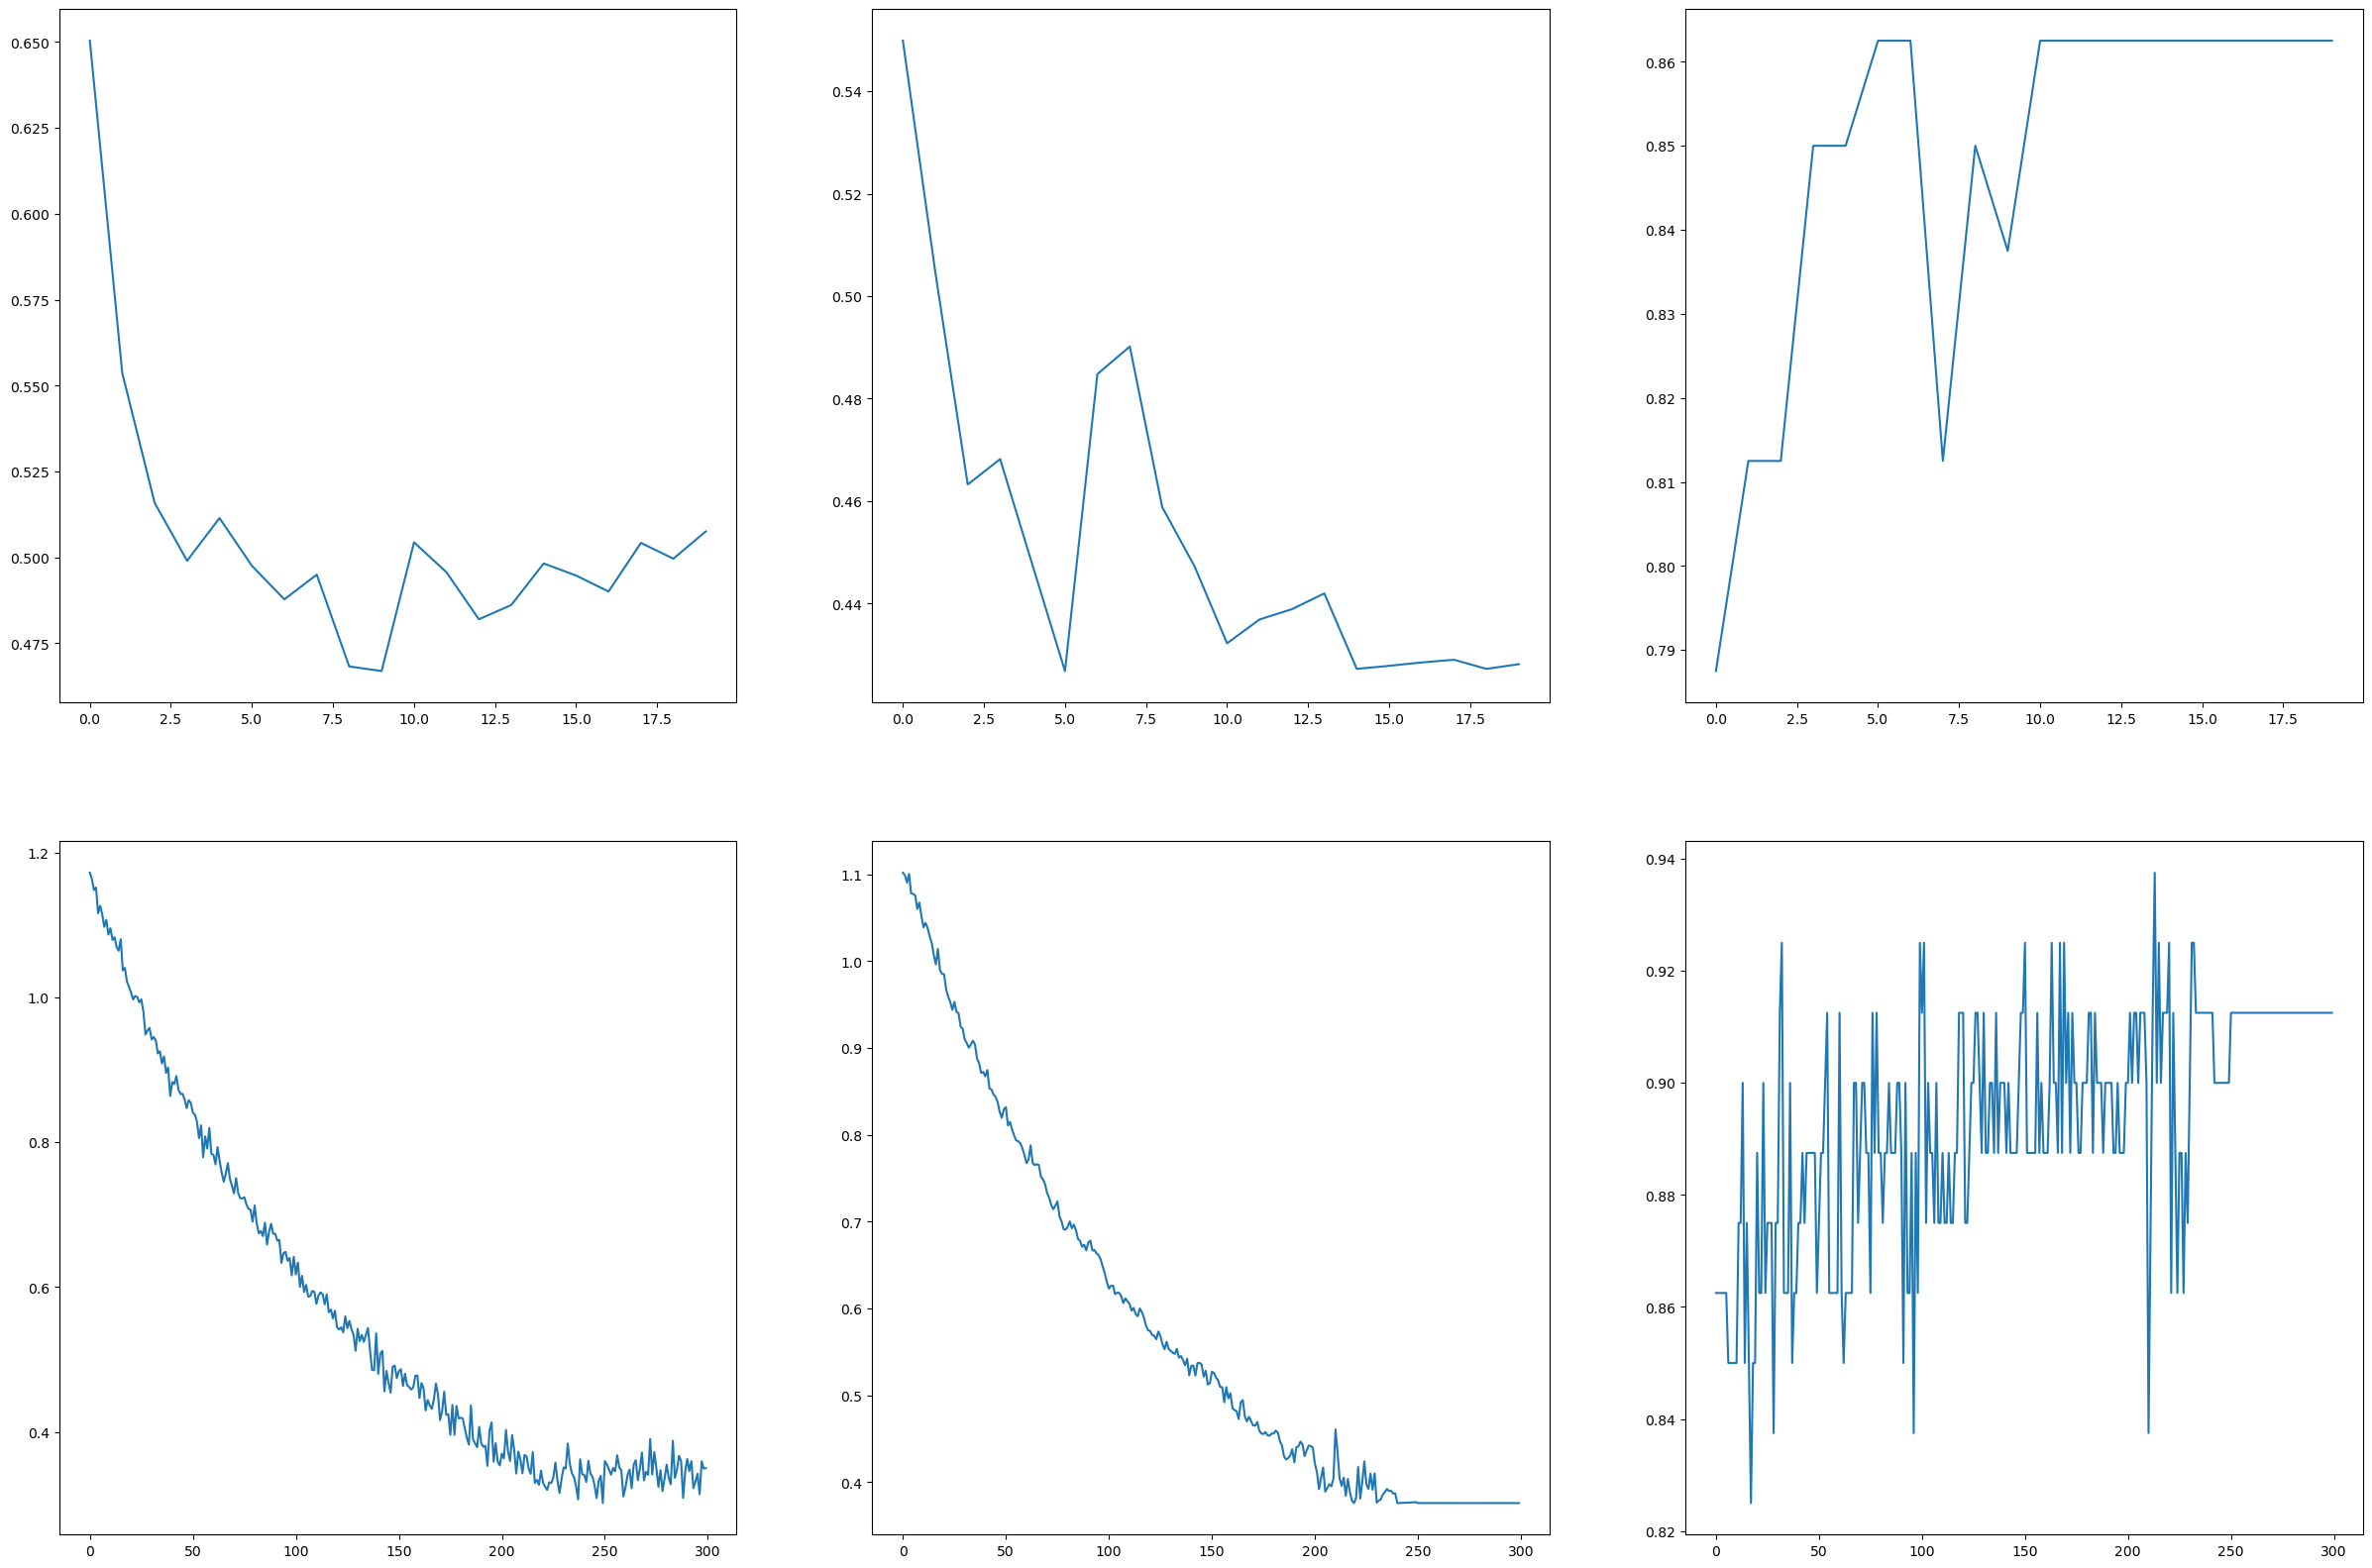

In [9]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(effnetv2m_dense_history['train_loss'])
plt.subplot(232)
plt.plot(effnetv2m_dense_history['val_loss'])
plt.subplot(233)
plt.plot(effnetv2m_dense_history['val_acc'])
plt.subplot(234)
plt.plot(effnetv2m_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(effnetv2m_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(effnetv2m_fine_tune_history['val_acc'])

## Test

In [10]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 1s 235ms/step - loss: 0.5218 - categorical_accuracy: 0.8194 - precision_4: 0.9302 - precision_5: 0.6552


# Resnet50

## Initialising

In [11]:
weights = '/home/jj/FYP/Checkpoint/Resnet50_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/Resnet50_INbreast_CLAHE/'
model, resnet_dense_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                             

## Fine Tune

In [12]:
model, resnet_fine_tune_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 22,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0   

## Figures

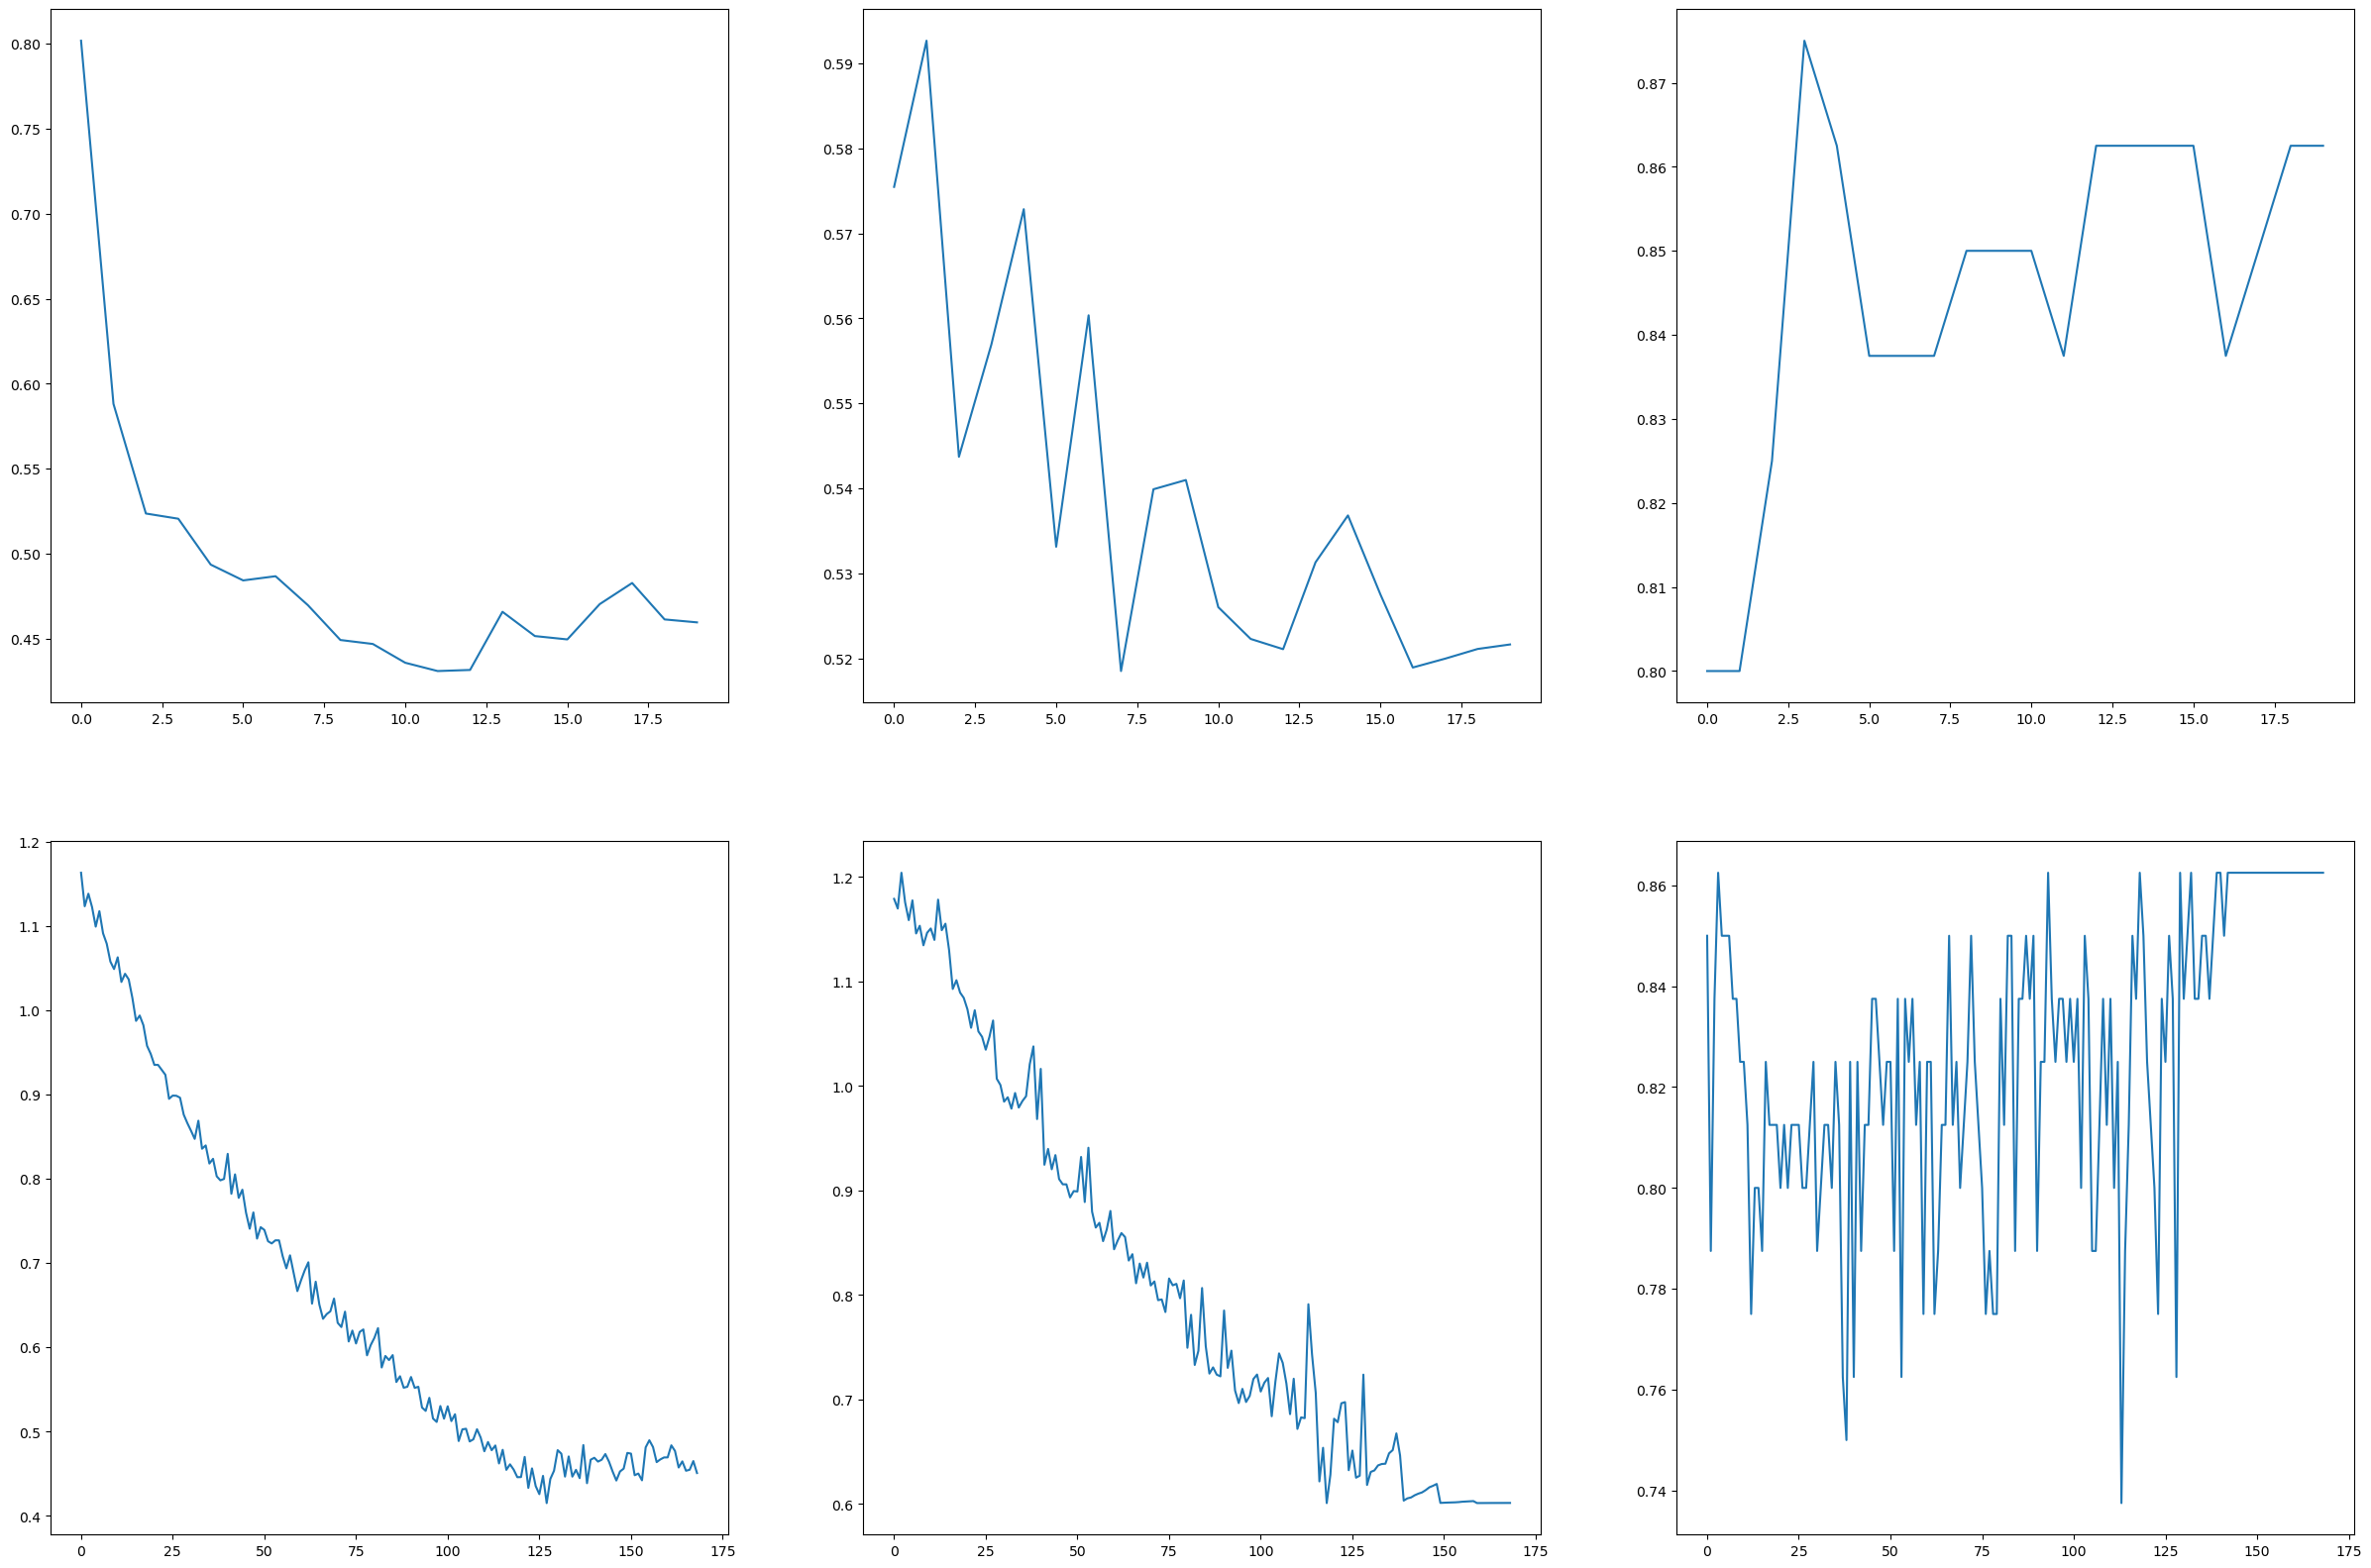

In [13]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(resnet_dense_history['train_loss'])
plt.subplot(232)
plt.plot(resnet_dense_history['val_loss'])
plt.subplot(233)
plt.plot(resnet_dense_history['val_acc'])
plt.subplot(234)
plt.plot(resnet_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(resnet_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(resnet_fine_tune_history['val_acc'])

## Test

In [14]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 1s 140ms/step - loss: 0.6923 - categorical_accuracy: 0.8611 - precision_2: 0.8704 - precision_3: 0.8333


# VGG16

In [15]:
weights = '/home/jj/FYP/Checkpoint/Vgg16_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/Vgg16_INbreast_CLAHE/'
model, vgg16_dense_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                             

2023-02-18 13:16:43.116416: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-18 13:16:43.116467: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


20/20 [==============================] - 10s 190ms/step - loss: 0.9105 - categorical_accuracy: 0.5125 - precision: 0.4961 - precision_1: 0.5233 - val_loss: 0.6799 - val_categorical_accuracy: 0.4625 - val_precision: 0.4795 - val_precision_1: 0.2857
Epoch 2/2
20/20 [==============================] - 4s 184ms/step - loss: 0.6366 - categorical_accuracy: 0.6500 - precision: 0.6319 - precision_1: 0.6688 - val_loss: 0.6009 - val_categorical_accuracy: 0.5125 - val_precision: 0.5070 - val_precision_1: 0.5556
Epoch 3/3
20/20 [==============================] - 4s 183ms/step - loss: 0.5516 - categorical_accuracy: 0.6875 - precision: 0.6440 - precision_1: 0.7519 - val_loss: 0.5511 - val_categorical_accuracy: 0.6375 - val_precision: 0.6000 - val_precision_1: 0.7200
Epoch 4/4
20/20 [==============================] - 4s 183ms/step - loss: 0.5816 - categorical_accuracy: 0.6344 - precision: 0.6159 - precision_1: 0.6538 - val_loss: 0.5313 - val_categorical_accuracy: 0.6125 - val_precision: 0.5763 - val_p

## Fine Tune

In [16]:
model, vgg16_fine_tune_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 16,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0   

2023-02-18 13:18:08.699114: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-18 13:18:08.699171: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


20/20 [==============================] - 9s 258ms/step - loss: 1.3452 - categorical_accuracy: 0.7437 - precision_2: 0.7017 - precision_3: 0.7986 - val_loss: 1.2051 - val_categorical_accuracy: 0.8625 - val_precision_2: 0.9143 - val_precision_3: 0.8222
Epoch 2/2
20/20 [==============================] - 5s 245ms/step - loss: 1.3422 - categorical_accuracy: 0.7156 - precision_2: 0.6860 - precision_3: 0.7500 - val_loss: 1.2572 - val_categorical_accuracy: 0.8125 - val_precision_2: 0.7551 - val_precision_3: 0.9032
Epoch 3/3
20/20 [==============================] - 5s 246ms/step - loss: 1.4892 - categorical_accuracy: 0.7937 - precision_2: 0.7543 - precision_3: 0.8414 - val_loss: 1.3550 - val_categorical_accuracy: 0.5000 - val_precision_2: 0.5000 - val_precision_3: 0.0000e+00
Epoch 4/4
20/20 [==============================] - 5s 245ms/step - loss: 1.3170 - categorical_accuracy: 0.7281 - precision_2: 0.6771 - precision_3: 0.8047 - val_loss: 1.2805 - val_categorical_accuracy: 0.8500 - val_precisio

## Figures

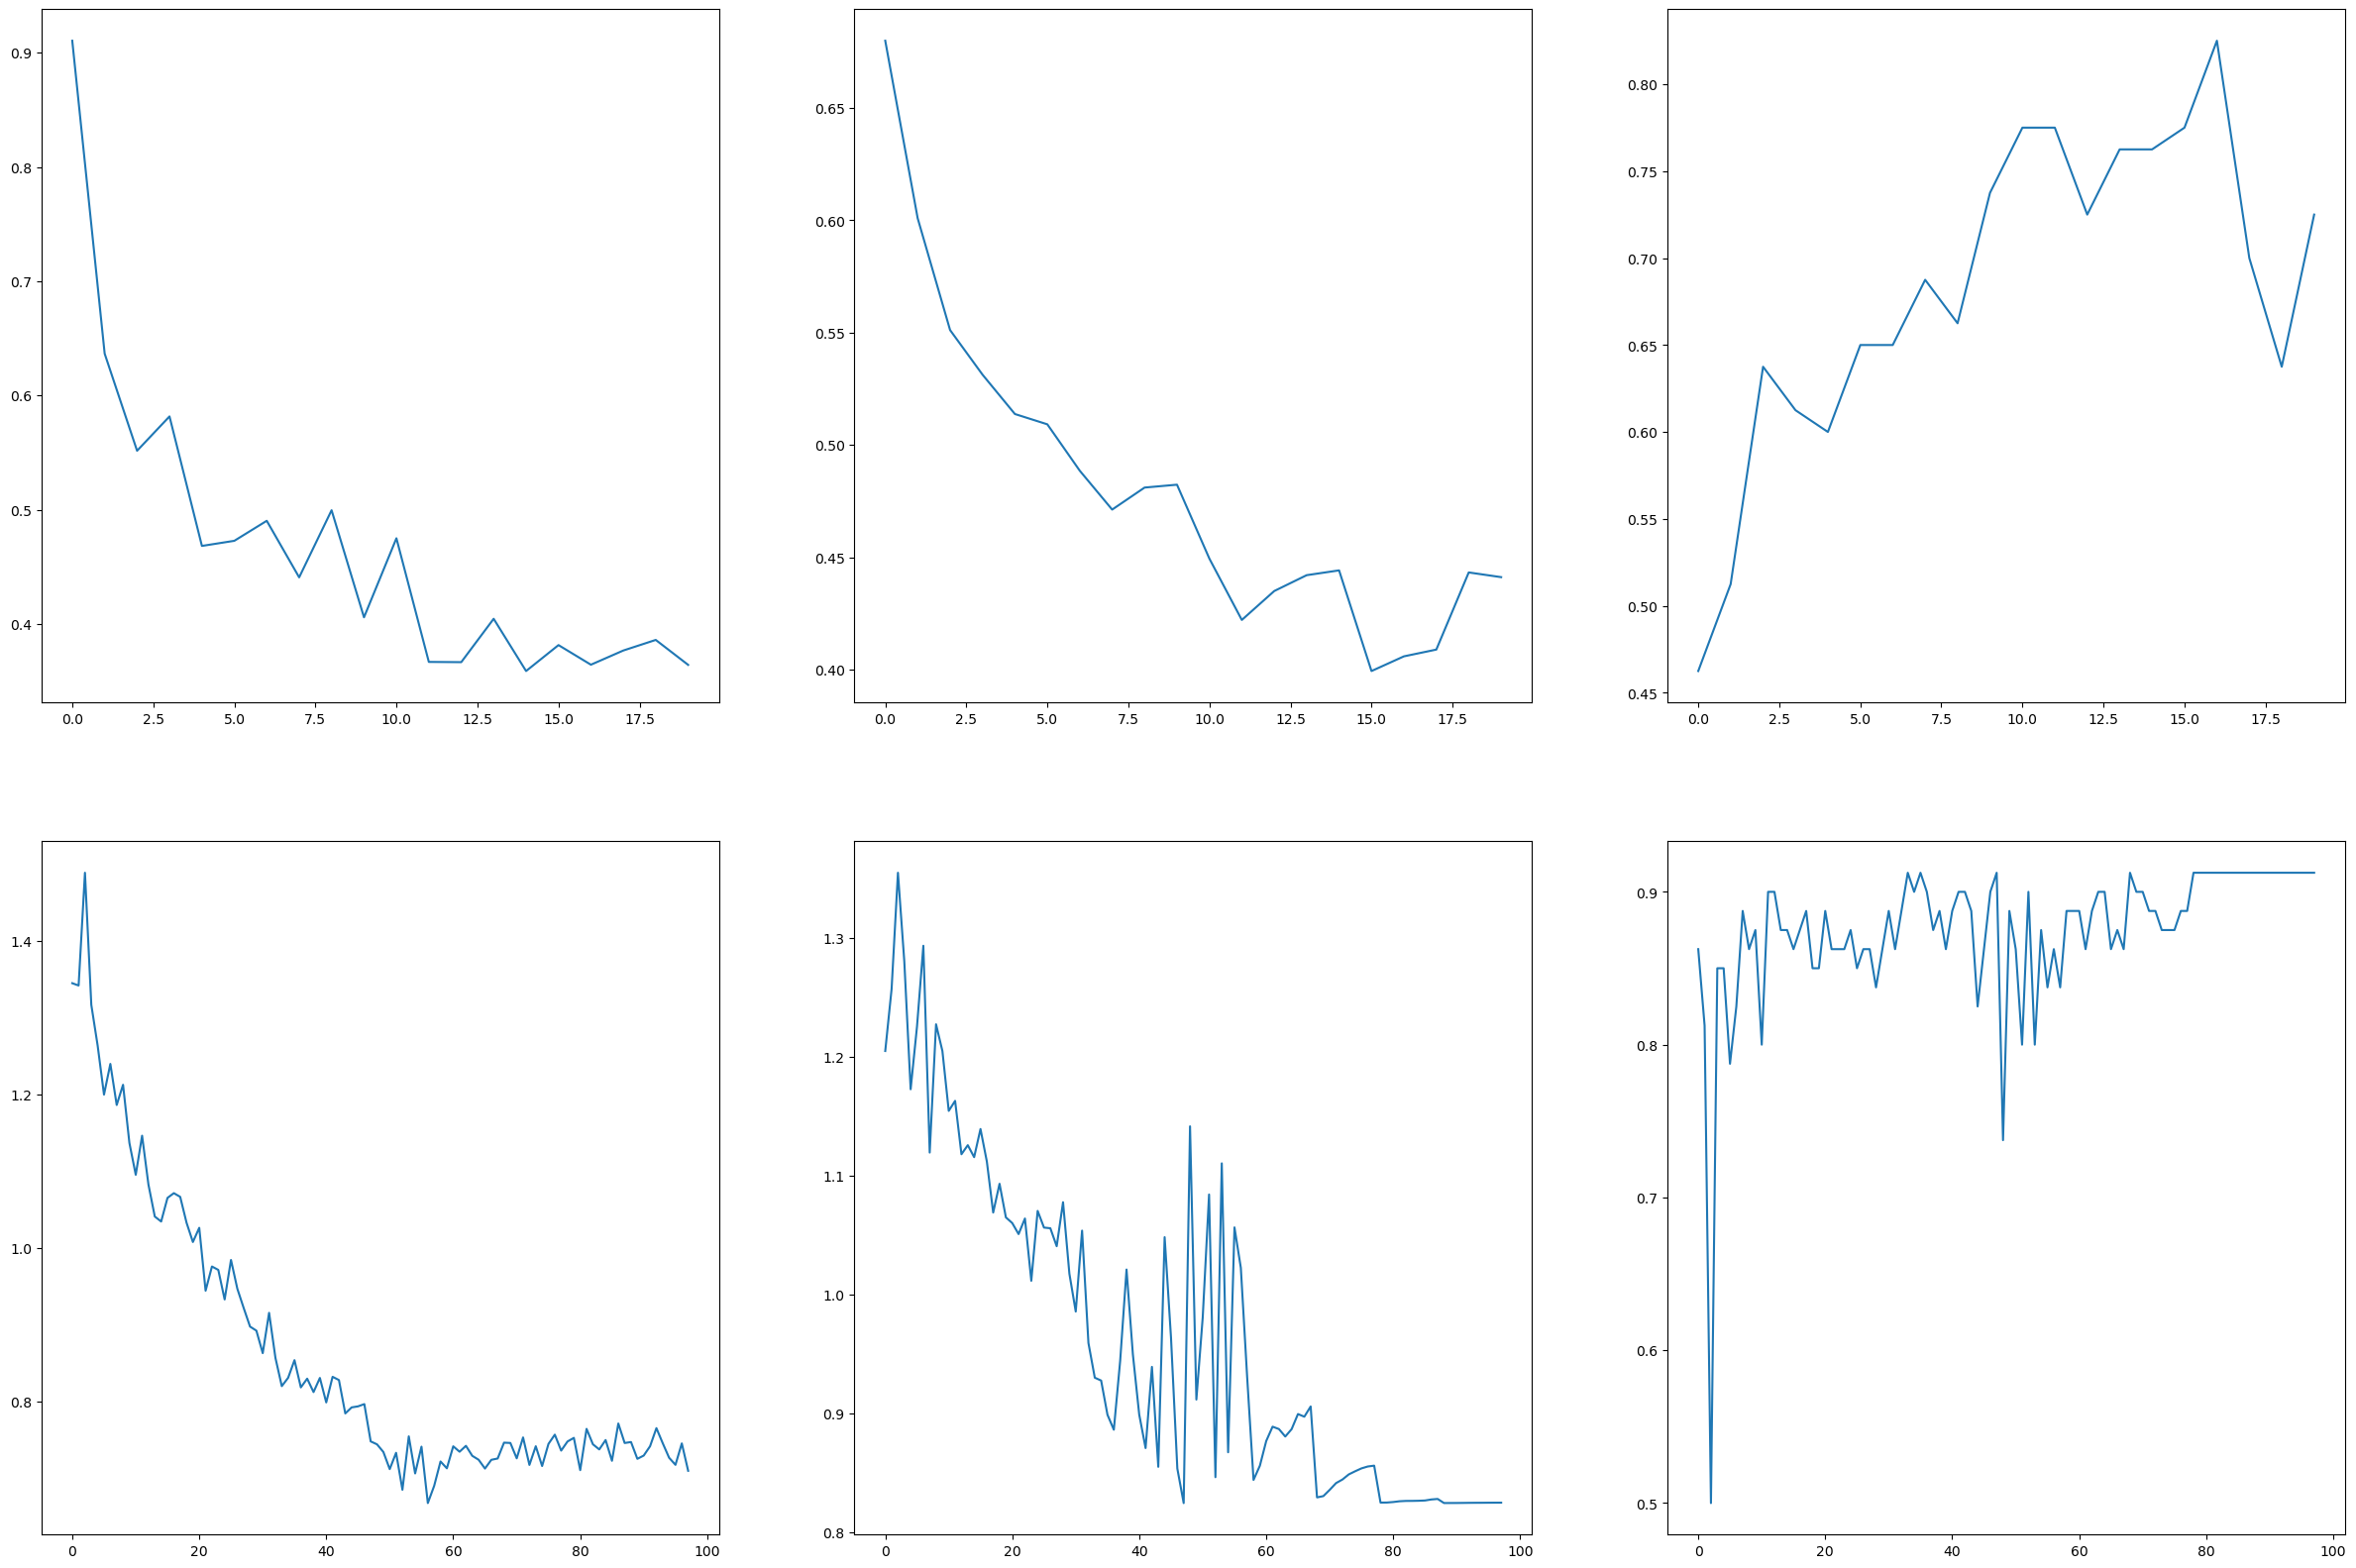

In [17]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(vgg16_dense_history['train_loss'])
plt.subplot(232)
plt.plot(vgg16_dense_history['val_loss'])
plt.subplot(233)
plt.plot(vgg16_dense_history['val_acc'])
plt.subplot(234)
plt.plot(vgg16_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(vgg16_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(vgg16_fine_tune_history['val_acc'])

## Test

In [18]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 2s 385ms/step - loss: 0.8391 - categorical_accuracy: 0.8611 - precision_2: 0.8846 - precision_3: 0.8000


# EfficientNet

In [19]:
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/EffcientNetB3_INbreast_CLAHE/'
model, effnet_dense_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 8)                 1228808   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0     

## Fine Tune

In [20]:
model, effnet_fine_tune_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten_1 (Flatten)         (None, 153600)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1228808   
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0   

## Figures

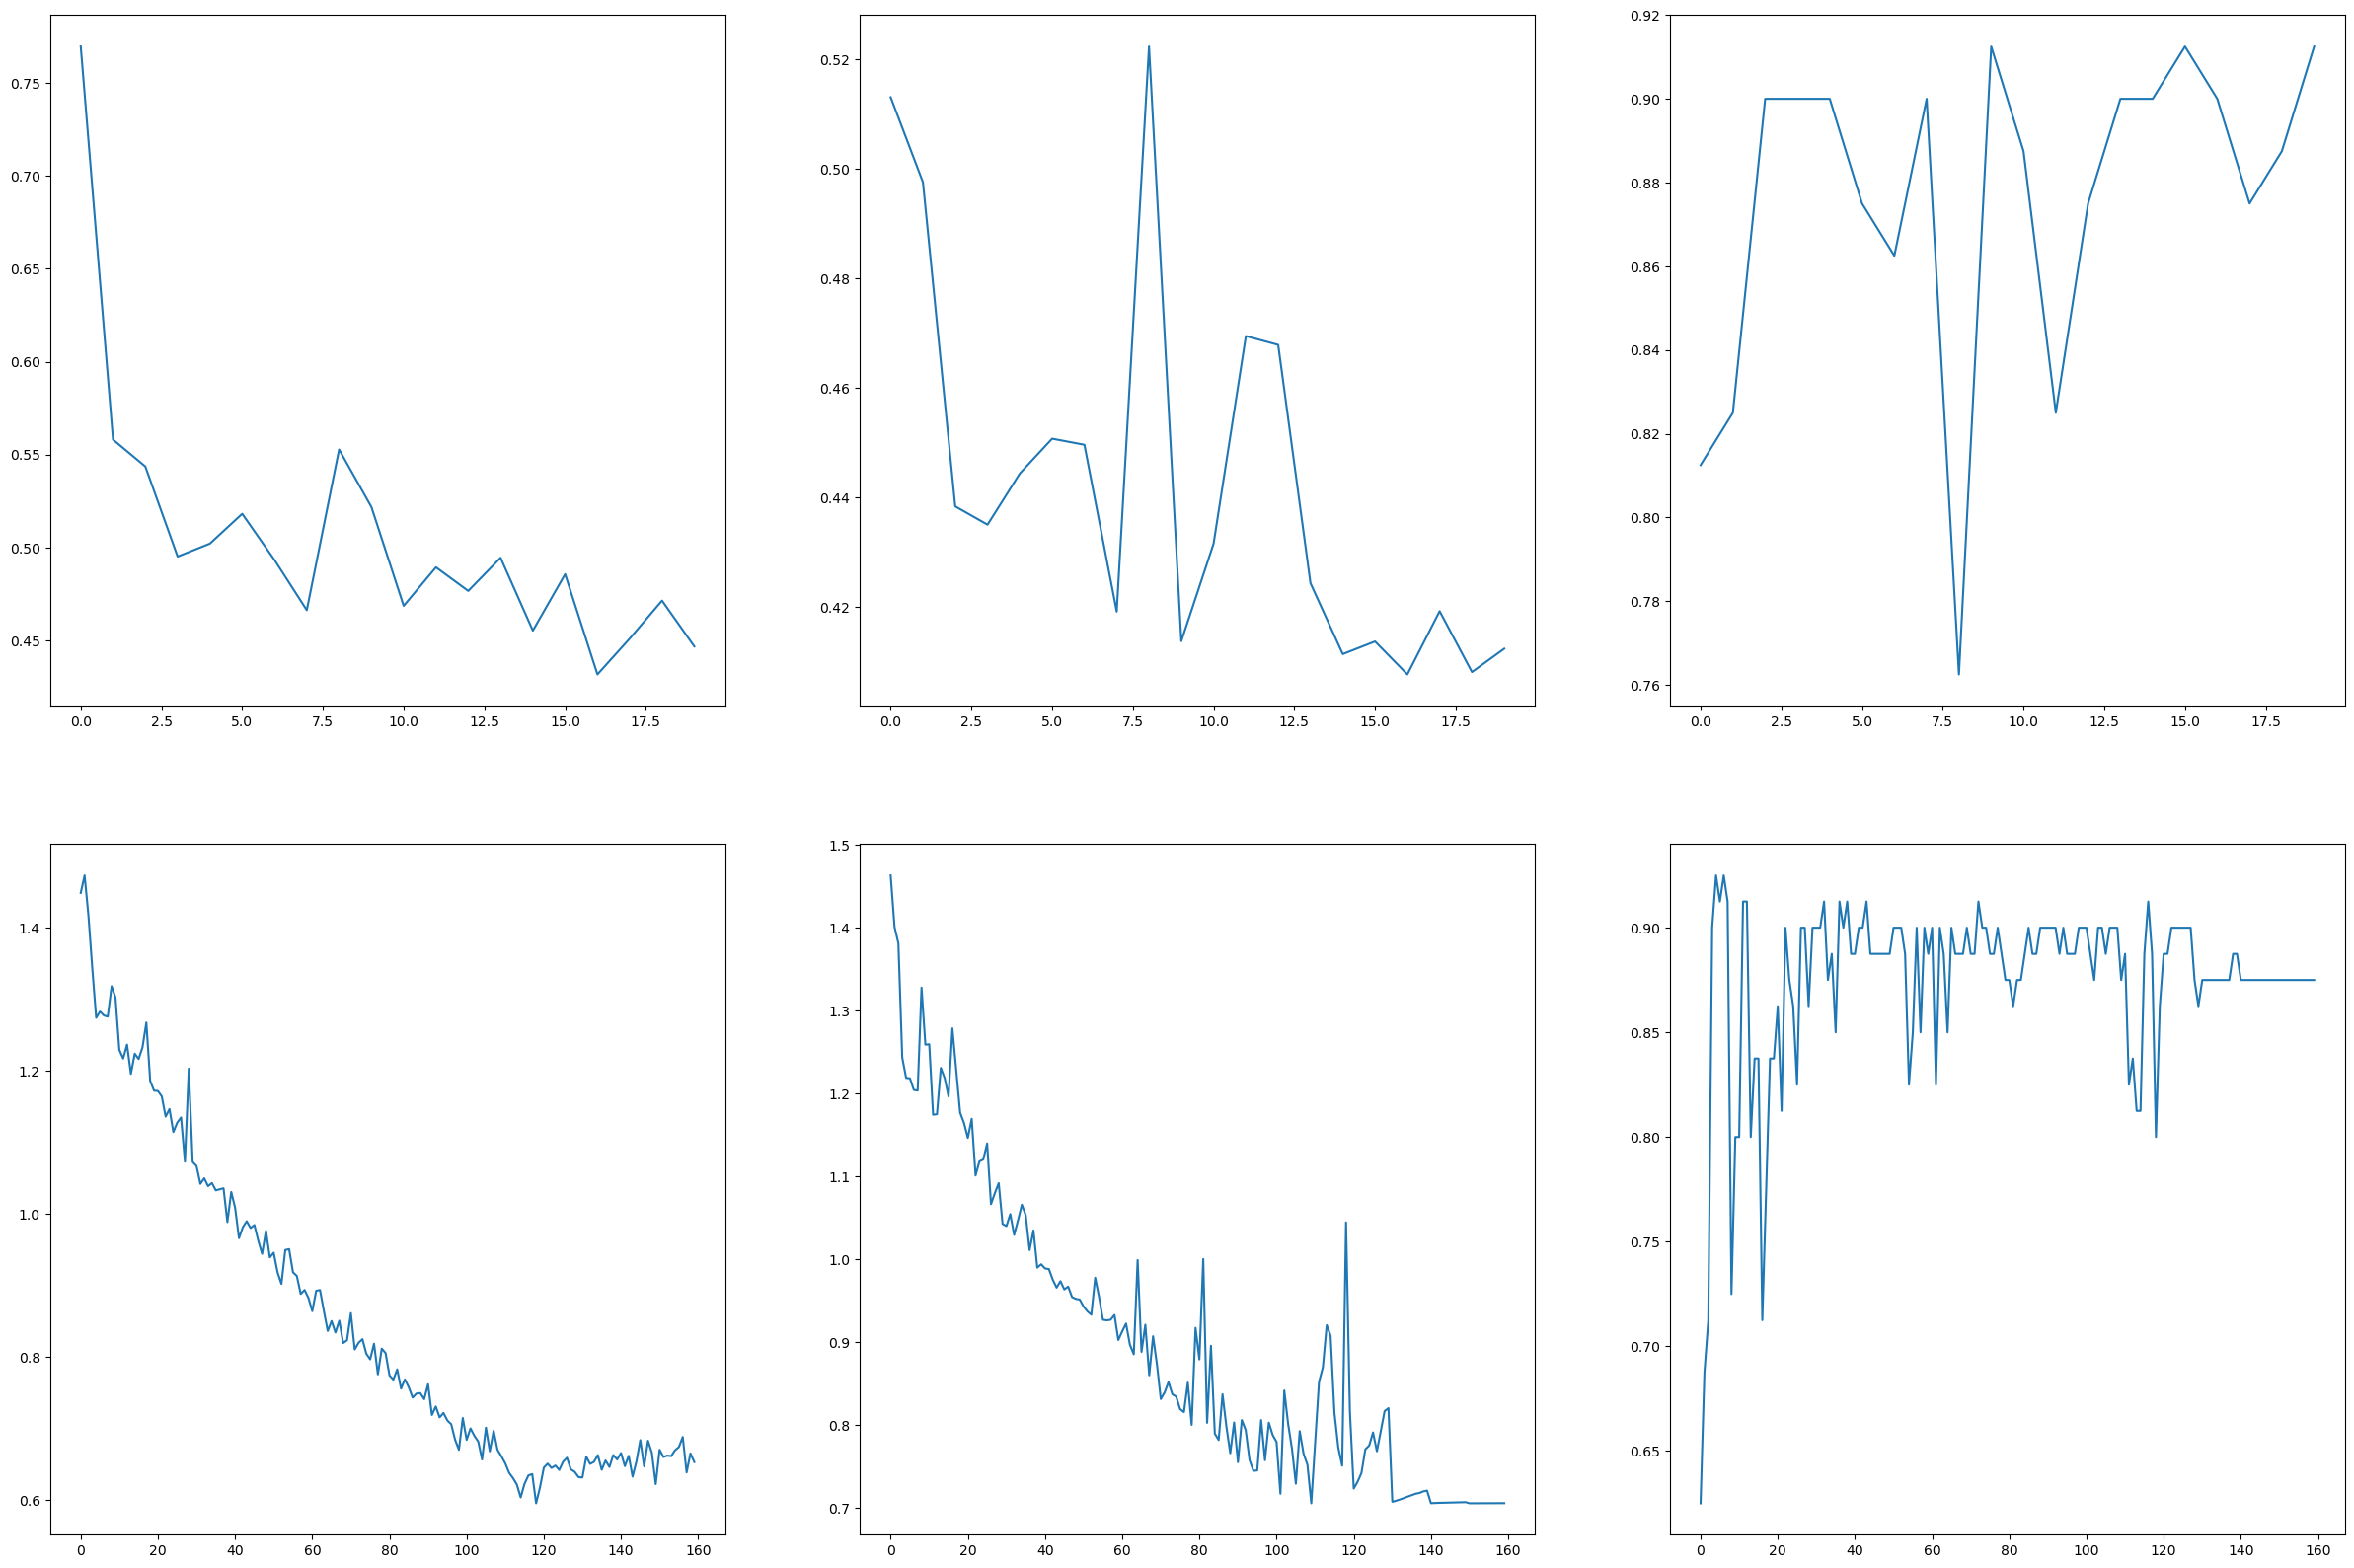

In [21]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(effnet_dense_history['train_loss'])
plt.subplot(232)
plt.plot(effnet_dense_history['val_loss'])
plt.subplot(233)
plt.plot(effnet_dense_history['val_acc'])
plt.subplot(234)
plt.plot(effnet_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(effnet_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(effnet_fine_tune_history['val_acc'])

## Test

In [22]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 1s 195ms/step - loss: 0.6597 - categorical_accuracy: 0.8750 - precision_2: 0.9556 - precision_3: 0.7407


# ConvNext

In [23]:
weights = '/home/jj/FYP/Checkpoint/Convnext_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/Convnext_INbreast_CLAHE/'

In [24]:
weights = '/home/jj/FYP/Checkpoint/Convnext_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/Convnext_INbreast_CLAHE/'
model, convnext_dense_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 8)                 663560    
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0     

## Fine Tune

In [25]:
model, convnext_fine_tune_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    # Top 25 layers are the stage 3 blocks
    trainable_layers = 25,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten_1 (Flatten)         (None, 82944)             0         
                                                                 
 dense_4 (Dense)             (None, 8)                 663560    
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0   

## Figures

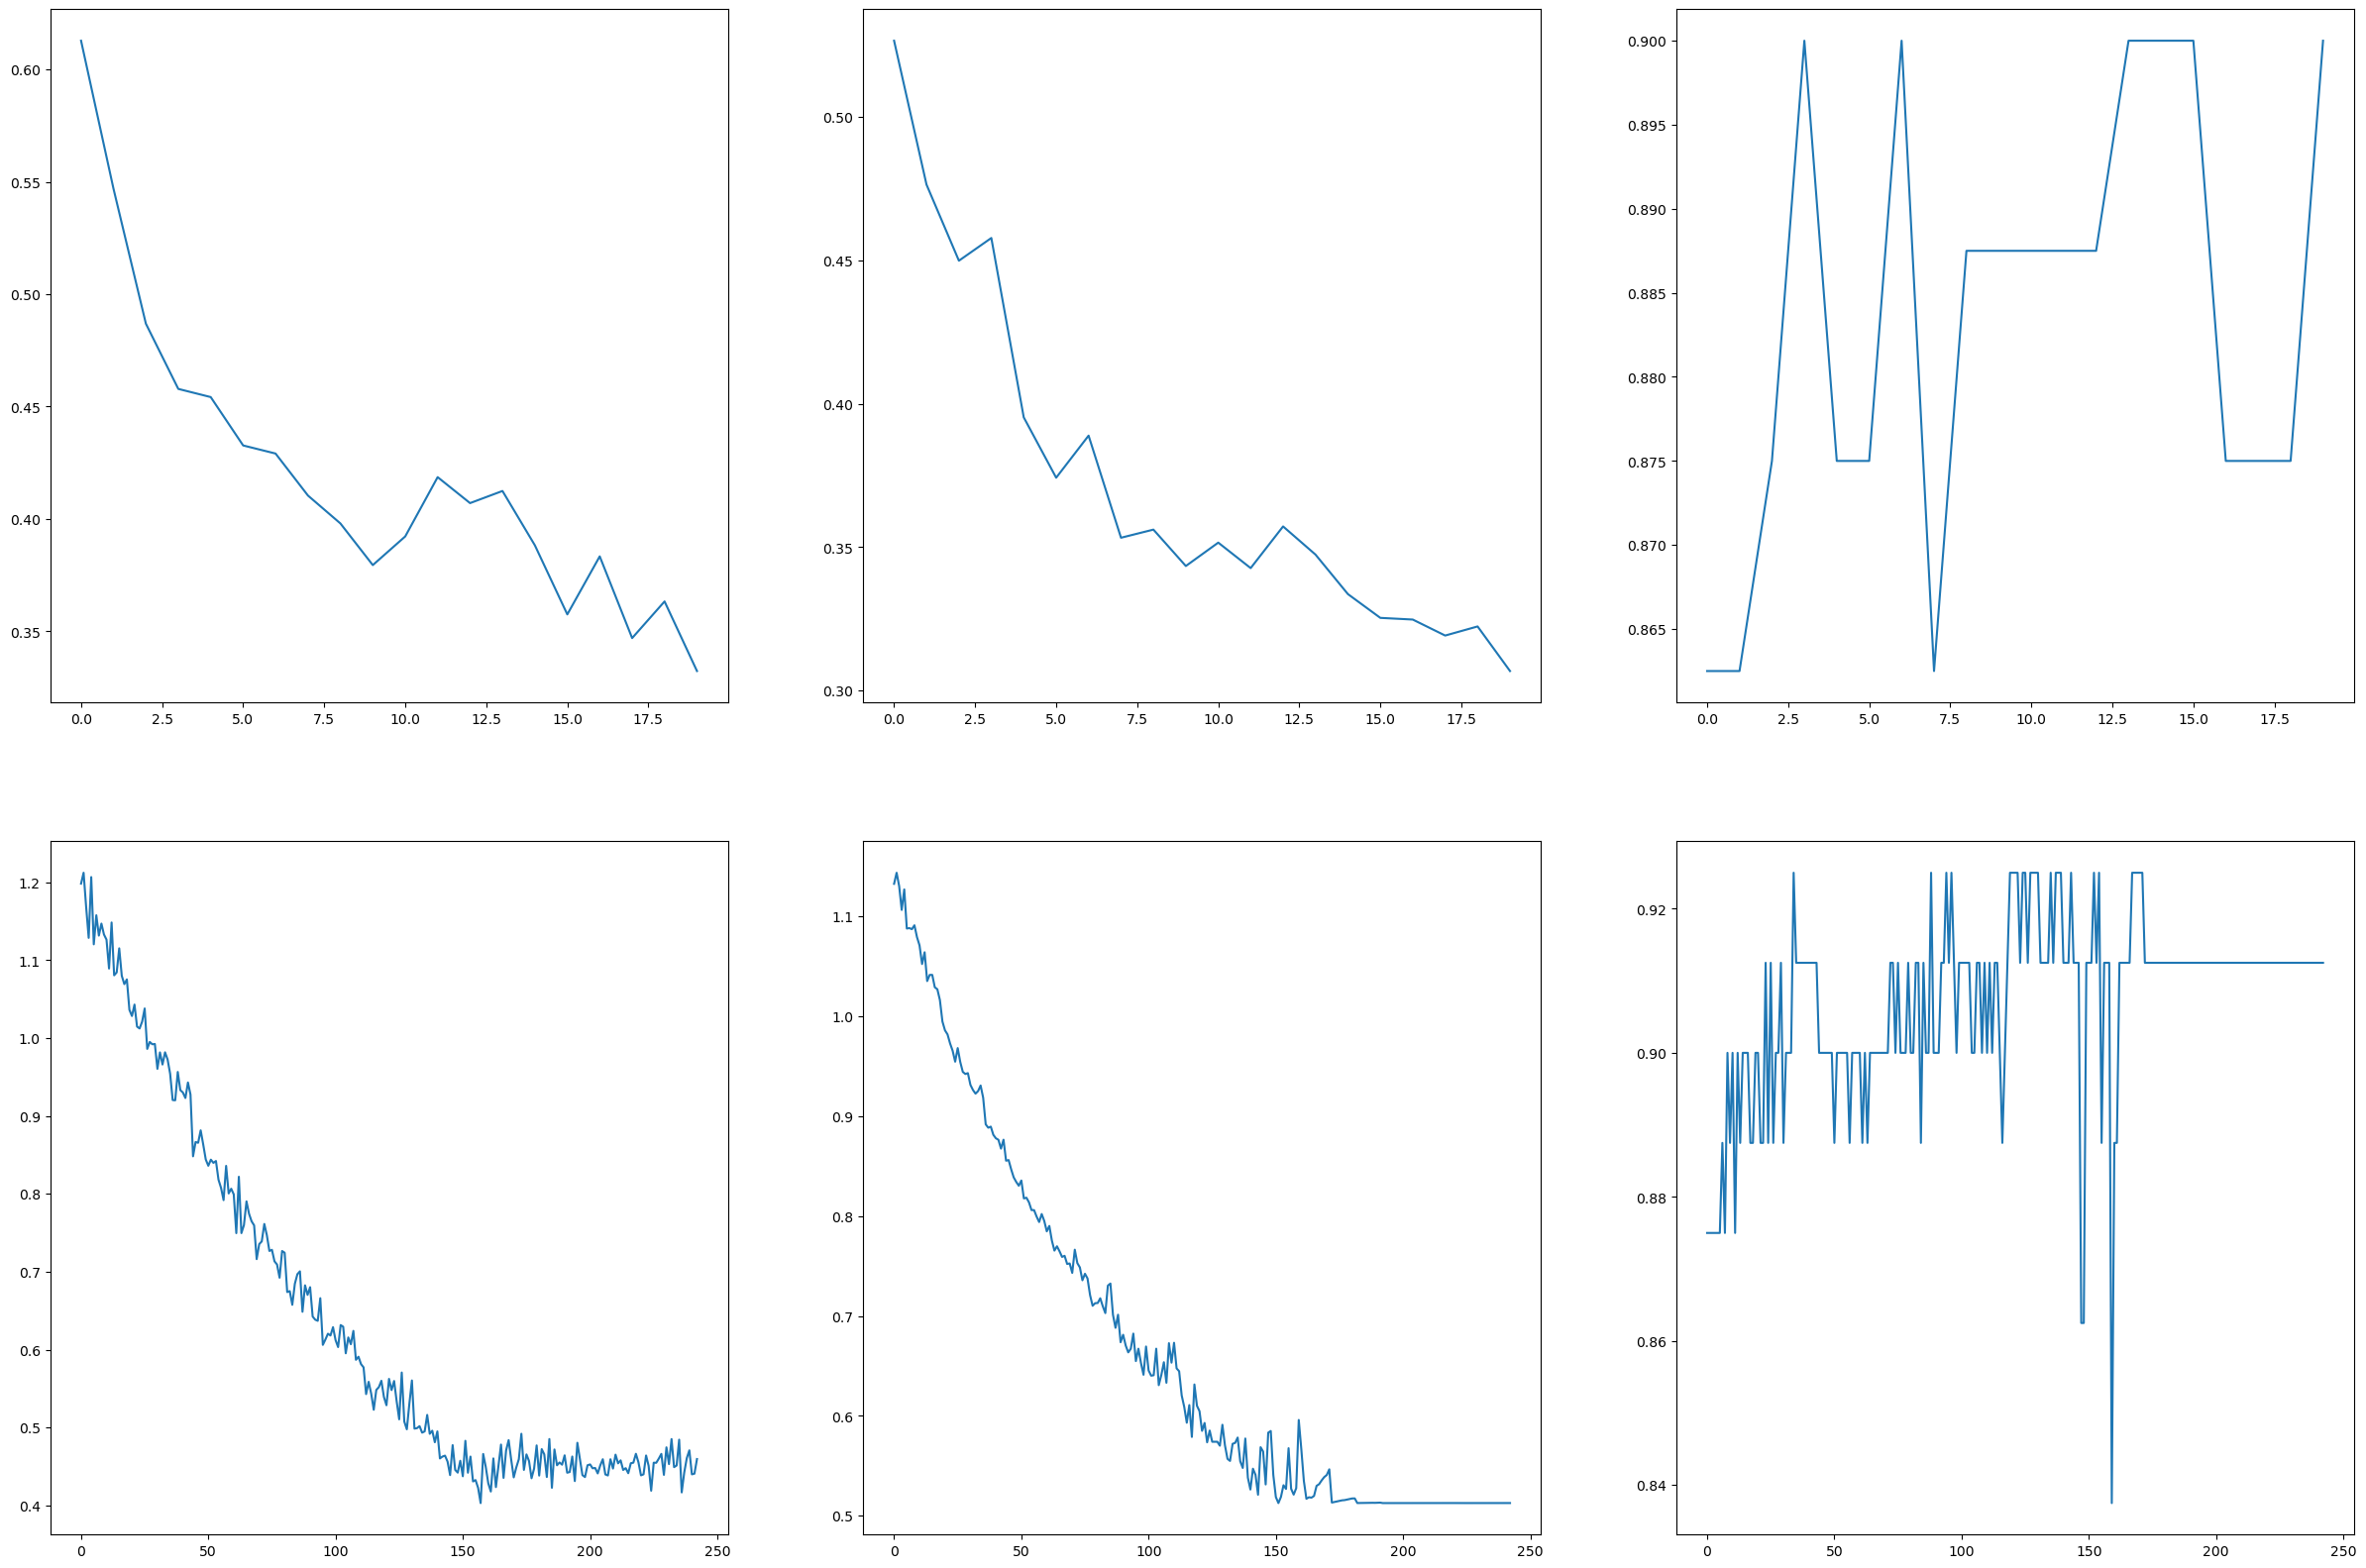

In [26]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(convnext_dense_history['train_loss'])
plt.subplot(232)
plt.plot(convnext_dense_history['val_loss'])
plt.subplot(233)
plt.plot(convnext_dense_history['val_acc'])
plt.subplot(234)
plt.plot(convnext_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(convnext_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(convnext_fine_tune_history['val_acc'])

## Test

In [27]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 3s 669ms/step - loss: 0.5881 - categorical_accuracy: 0.8472 - precision_2: 0.8421 - precision_3: 0.8667
